In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data.

mydata = pd.read_csv("C:/Users/yingy/Desktop/life/ms study/math/5330 Data Mining/project/data/train_ver2.csv", 
                     dtype = {"sexo": str, "ind_nuevo": str, "ult_fec_cli_1t": str, "indext": str})

C:\Users\yingy\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# There are around 14 million records, with around 1 million virtual customers.
# There are together 48 variables for each record: the first 24 are demographic information; the following 24 are each client’s product purchase history.

print(mydata.shape)
print(len(mydata["ncodpers"].unique()))

(13647309, 48)
956645


In [4]:
mydata.head(5)

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [5]:
# Calculate proportion of missing data in each column.
# Notice that, the missings may not be found for some columns due to the way of encoding.

mydata.isnull().mean() * 100

fecha_dato                0.000000
ncodpers                  0.000000
ind_empleado              0.203220
pais_residencia           0.203220
sexo                      0.203732
age                       0.000000
fecha_alta                0.203220
ind_nuevo                 0.203220
antiguedad                0.000000
indrel                    0.203220
ult_fec_cli_1t           99.818330
indrel_1mes               1.097513
tiprel_1mes               1.097513
indresi                   0.203220
indext                    0.203220
conyuemp                 99.986752
canal_entrada             1.363829
indfall                   0.203220
tipodom                   0.203227
cod_prov                  0.685784
nomprov                   0.685784
ind_actividad_cliente     0.203220
renta                    20.475648
segmento                  1.387585
ind_ahor_fin_ult1         0.000000
ind_aval_fin_ult1         0.000000
ind_cco_fin_ult1          0.000000
ind_cder_fin_ult1         0.000000
ind_cno_fin_ult1    

Next, let's look at the first 24 variables one by one. 
- For some we may conduct some processing - change the type of data, do some EDA, impute missings, and so on. 
- For the other we just demonstrate what they look like.

In the implementation of SVD and XGBoost, we may apply some slightly different ways to process data.

In [6]:
# (1) "fecha_dato": no missing.
# Date, range from 2015-01-28 to 2016-05-28.

mydata["fecha_dato"].unique()

array(['2015-01-28', '2015-02-28', '2015-03-28', '2015-04-28',
       '2015-05-28', '2015-06-28', '2015-07-28', '2015-08-28',
       '2015-09-28', '2015-10-28', '2015-11-28', '2015-12-28',
       '2016-01-28', '2016-02-28', '2016-03-28', '2016-04-28',
       '2016-05-28'], dtype=object)

In [7]:
# (2) "ncodpers": no missing.
# Customer code, 956645 customers in total.

len(mydata["ncodpers"].unique())

956645

In [8]:
# (3) ind_empleado: 0.203220 missing. 
# Employee index, A active, B ex employed, F filial, N not employee, P pasive.

mydata['ind_empleado'].unique()

array(['N', nan, 'A', 'B', 'F', 'S'], dtype=object)

In [9]:
mydata['ind_empleado'].value_counts(normalize=True)

N    0.999369
B    0.000262
F    0.000185
A    0.000183
S    0.000001
Name: ind_empleado, dtype: float64

We can notice that, 0.203220 is a common missing proportion, occuring in many columns. After exploring, we find that these correspond to the same rows, which may represent some new customers. Thus, there are two ways of imputing.

- Treat them as a different category, and assign them a different type/number.
- Treat them as new customers (which is our assumption), and assign them the value related to new customer. For example, for 8th variable "ind_nuevo" representing whether new customer or not, we can assign them "1". And for 3rd varible 'ind_empleado', we can assign them 'N' since we may believe they are not employees.

In [10]:
# (4) "pais_residencia": 0.203220 missing.
# Customer's country residence.

mydata['pais_residencia'].unique()

array(['ES', nan, 'CA', 'CH', 'CL', 'IE', 'AT', 'NL', 'FR', 'GB', 'DE',
       'DO', 'BE', 'AR', 'VE', 'US', 'MX', 'BR', 'IT', 'EC', 'PE', 'CO',
       'HN', 'FI', 'SE', 'AL', 'PT', 'MZ', 'CN', 'TW', 'PL', 'IN', 'CR',
       'NI', 'HK', 'AD', 'CZ', 'AE', 'MA', 'GR', 'PR', 'RO', 'IL', 'RU',
       'GT', 'GA', 'NO', 'SN', 'MR', 'UA', 'BG', 'PY', 'EE', 'SV', 'ET',
       'CM', 'SA', 'CI', 'QA', 'LU', 'PA', 'BA', 'BO', 'AU', 'BY', 'KE',
       'SG', 'HR', 'MD', 'SK', 'TR', 'AO', 'CU', 'GQ', 'EG', 'ZA', 'DK',
       'UY', 'GE', 'TH', 'DZ', 'LB', 'JP', 'NG', 'PK', 'TN', 'TG', 'KR',
       'GH', 'RS', 'VN', 'PH', 'KW', 'NZ', 'MM', 'KH', 'GI', 'SL', 'GN',
       'GW', 'OM', 'CG', 'LV', 'LT', 'ML', 'MK', 'HU', 'IS', 'LY', 'CF',
       'GM', 'KZ', 'CD', 'BZ', 'ZW', 'DJ', 'JM', 'BM', 'MT'], dtype=object)

In [11]:
# Most customers reside in ES (over 99.5%).

mydata['pais_residencia'].value_counts(normalize=True).head(5)

ES    0.995164
FR    0.000379
AR    0.000355
DE    0.000340
GB    0.000338
Name: pais_residencia, dtype: float64

In [12]:
# (5) "sexo": 0.203732 missing.
# Customer's sex.

print(mydata['sexo'].unique())
mydata['sexo'].value_counts(normalize=True)

['H' 'V' nan]


V    0.545119
H    0.454881
Name: sexo, dtype: float64

In [13]:
# (6) "age": showing no missing, but actually with NA.
# First transform to numbers, will turn NA into nan and then we can recognize missing values.

mydata['age'] = pd.to_numeric(mydata["age"], errors="coerce")
mydata['age'].unique()

array([ 35.,  23.,  22.,  24.,  65.,  28.,  25.,  26.,  53.,  27.,  32.,
        37.,  31.,  39.,  63.,  33.,  55.,  42.,  58.,  38.,  50.,  30.,
        45.,  44.,  36.,  29.,  60.,  57.,  67.,  47.,  nan,  34.,  48.,
        46.,  54.,  84.,  15.,  12.,   8.,   6.,  83.,  40.,  77.,  69.,
        52.,  59.,  43.,  10.,   9.,  49.,  41.,  51.,  78.,  16.,  11.,
        73.,  62.,  66.,  17.,  68.,  82.,  95.,  96.,  56.,  61.,  79.,
        72.,  14.,  19.,  13.,  86.,  64.,  20.,  89.,  71.,   7.,  70.,
        74.,  21.,  18.,  75.,   4.,  80.,  81.,   5.,  76.,  92.,  93.,
        85.,  91.,  87.,  90.,  94.,  99.,  98.,  88.,  97., 100., 101.,
       106., 103.,   3.,   2., 102., 104., 111., 107., 109., 105., 112.,
       115., 110., 116., 108., 113., 126., 117., 163., 127., 114., 164.])

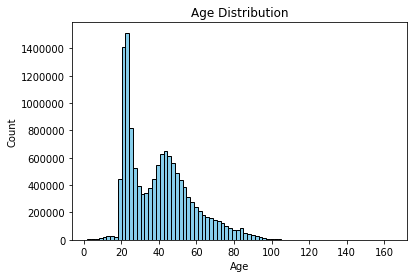

In [14]:
# Plot histogram of Age.

plt.hist(mydata['age'].dropna(), bins=80, color='skyblue', edgecolor='black')
 
plt.xlabel('Age')               # Adding labels and title.
plt.ylabel('Count')
plt.title('Age Distribution')

plt.show()                         # Display the plot.

In [15]:
# We impute the missing with mean value (40).
# We also set a range of age, and round ages outside the range to its nearset bound.

mydata['age'].fillna(40, inplace=True)
mydata.loc[mydata.age < 15,'age']  = 15
mydata.loc[mydata.age > 100,'age'] = 100                                                        
mydata['age'] = mydata['age'].astype(int)

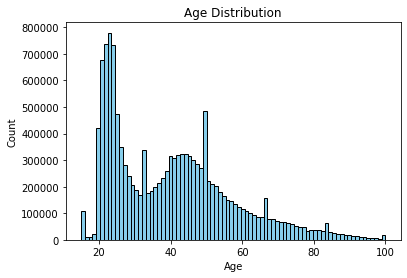

In [16]:
# Plotting histogram of Age after processing.

plt.hist(mydata['age'], bins=80, color='skyblue', edgecolor='black')
 
plt.xlabel('Age')               # Adding labels and title.
plt.ylabel('Count')
plt.title('Age Distribution')

plt.show()                         # Display the plot.

In [17]:
# (7) "fecha_alta": 0.203220 missing.
# The date in which the customer became as the first holder of a contract in the bank.
# For now, we do little with variable in the form of date.

mydata['fecha_alta'].unique()

array(['2015-01-12', '2012-08-10', nan, ..., '2016-05-25', '2016-05-01',
       '2016-05-15'], dtype=object)

In [18]:
# (8) "ind_nuevo" : 0.203220 missing.
# New customer Index. 1 if the customer registered in the last 6 months.
# Notice that all missings are new customers, so replace accordingly.

mydata['ind_nuevo'].unique()

array([' 0', nan, ' 1'], dtype=object)

In [19]:
mydata['ind_nuevo'].fillna(' 1', inplace=True)
mydata['ind_nuevo'].unique()

array([' 0', ' 1'], dtype=object)

In [20]:
# (9) "antiguedad": showing no missing, but actually with NA.
# Customer seniority (in months)

mydata['antiguedad'].unique()

array(['      6', '     35', '     34', '     NA', '     33', '     31',
       '     21', '     16', '     27', '      9', '     22', '     13',
       '     29', '      8', '     11', '     10', '     28', '     24',
       '      7', '     25', '     14', '     26', '     12', '     23',
       '      1', '     18', '      4', '      3', '     17', '     32',
       '     30', '     20', '     15', '     19', '    157', '     36',
       '      5', '     40', '     38', '     37', '     39', '      0',
       '      2', '     47', '     44', '     42', '     46', '     45',
       '     43', '     41', '     57', '     48', '     52', '     49',
       '     50', '     56', '     58', '     51', '     55', '     54',
       '     53', '     59', '     62', '     61', '     60', '     63',
       '    139', '    165', '    118', '    164', '    142', '     94',
       '    159', '    143', '    105', '    151', '    162', '    137',
       '    150', '    128', '    122', '    156', 

In [21]:
# Notice that the missings are from the same group of new customers, so let's give them minimum seniority.

mydata.antiguedad = pd.to_numeric(mydata.antiguedad, errors="coerce")
mydata.loc[mydata.antiguedad.isnull(), "antiguedad"] = 0
mydata.loc[mydata.antiguedad < 0, "antiguedad"]      = 0

In [22]:
# (10) "indrel": 0.203220 missing.
# 1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)
# Fill in missing with another different type.

print(mydata['indrel'].unique())\

mydata['indrel'].fillna(2., inplace=True)
mydata['indrel'].unique()

[ 1. nan 99.]


array([ 1.,  2., 99.])

In [23]:
# (11) "ult_fec_cli_1t": 99.818330 missing.
# Last date as primary customer (if he isn't at the end of the month).
# For now, we do little with variable in the form of date.
# Since there are majority of missings here, we also consider not to use this column.

In [24]:
# (12) "indrel_1mes": 1.097513 missing.
# Customer type at the beginning of the month, 1 (First/Primary customer), 2 (co-owner ),P (Potential),3 (former primary), 4 (former co-owner).
# Fill in missing with another different type.

mydata['indrel_1mes'].unique()

array([1.0, nan, 3.0, 2.0, '1.0', '1', '3', '3.0', '2.0', '4.0', 'P', '4',
       4.0, '2'], dtype=object)

In [25]:
# (13) "tiprel_1mes": 1.097513 missing.
# Customer relation type at the beginning of the month, A (active), I (inactive), P (former customer),R (Potential).
# Fill in missing with another different type.

mydata['tiprel_1mes'].unique()

array(['A', 'I', nan, 'P', 'R', 'N'], dtype=object)

In [26]:
# (14) "indresi": 0.203220 missing.
# Residence index (S (Yes) or N (No) if the residence country is the same than the bank country)
# Fill in missing with another different type.

mydata['indresi'].unique()

array(['S', nan, 'N'], dtype=object)

In [27]:
# (15) "indext": 0.203220 missing.
# Foreigner index (S (Yes) or N (No) if the customer's birth country is different than the bank country).
# Fill in missing with another different type.

mydata['indext'].unique()

array(['N', 'S', nan], dtype=object)

In [28]:
# (16) "conyuemp": 99.986752 missing.
# Spouse index. 1 if the customer is spouse of an employee.
# Fill in missing with another different type.

mydata['conyuemp'].unique()

array([nan, 'N', 'S'], dtype=object)

In [29]:
# (17) "canal_entrada": 1.363829 missing.
# Channel used by the customer to join.
# Fill in missing with another different type.

mydata['canal_entrada'].unique()

array(['KHL', 'KHE', 'KHD', 'KFA', 'KFC', 'KAT', nan, 'KAZ', 'RED', 'KHC',
       'KHK', 'KGN', 'KHM', 'KHO', 'KDH', 'KEH', 'KAD', 'KBG', 'KGC',
       'KHF', 'KFK', 'KHN', 'KHA', 'KAF', 'KGX', 'KFD', 'KAG', 'KFG',
       'KAB', 'KCC', 'KAE', 'KAH', 'KAR', 'KFJ', 'KFL', 'KAI', 'KFU',
       'KAQ', 'KFS', 'KAA', 'KFP', 'KAJ', 'KFN', 'KGV', 'KGY', 'KFF',
       'KAP', 'KDE', 'KFV', '013', 'K00', 'KAK', 'KCK', 'KCL', 'KAY',
       'KBU', 'KDR', 'KAC', 'KDT', 'KCG', 'KDO', 'KDY', 'KBQ', 'KDA',
       'KBO', 'KCI', 'KEC', 'KBZ', 'KES', 'KDX', 'KAS', '007', 'KEU',
       'KCA', 'KAL', 'KDC', 'KAW', 'KCS', 'KCB', 'KDU', 'KDQ', 'KCN',
       'KCM', '004', 'KCH', 'KCD', 'KCE', 'KEV', 'KBL', 'KEA', 'KBH',
       'KDV', 'KFT', 'KEY', 'KAO', 'KEJ', 'KEO', 'KEI', 'KEW', 'KDZ',
       'KBV', 'KBR', 'KBF', 'KDP', 'KCO', 'KCF', 'KCV', 'KAM', 'KEZ',
       'KBD', 'KAN', 'KBY', 'KCT', 'KDD', 'KBW', 'KCU', 'KBX', 'KDB',
       'KBS', 'KBE', 'KCX', 'KBP', 'KBN', 'KEB', 'KDS', 'KEL', 'KDG',
       'KDF', '

In [30]:
# (18) "indfall": 0.203220 missing.
# Deceased index. N/S.
# Fill in missing with another different type.

mydata['indfall'].unique()

array(['N', nan, 'S'], dtype=object)

In [31]:
# (19) "tipodom":0.203227 missing.
# Address type. 1, primary address. We delete this variable since all of them are 1 (or missing).

mydata['tipodom'].unique()

array([ 1., nan])

In [32]:
# (20) "cod_prov": 0.685784 missing.
# Province code (customer's address).
# Fill in missing with another different type.

mydata['cod_prov'].unique()

array([29., 13., 50., 45., 24., 20., 10., 17., 49.,  8., 37.,  9., 22.,
       31.,  5., 40., 27., 25., 28.,  3., 42., 41., 39.,  7., 47., 36.,
       46., 44., 15., 32., 23., 16., 48., 12., 26.,  2.,  6., 30., 11.,
       nan,  4., 19., 34., 35., 14., 21., 18., 33., 38., 52., 43.,  1.,
       51.])

In [33]:
mydata['cod_prov'].value_counts(normalize=True).head(5)

28.0    0.325342
8.0     0.094086
46.0    0.050341
41.0    0.044649
15.0    0.031676
Name: cod_prov, dtype: float64

In [34]:
# (21) "nomprov": 0.685784 missing.
# Province name. Ignore this variable, as it is totally the same as 'cod_prov'.

mydata['nomprov'].unique()

array(['MALAGA', 'CIUDAD REAL', 'ZARAGOZA', 'TOLEDO', 'LEON', 'GIPUZKOA',
       'CACERES', 'GIRONA', 'ZAMORA', 'BARCELONA', 'SALAMANCA', 'BURGOS',
       'HUESCA', 'NAVARRA', 'AVILA', 'SEGOVIA', 'LUGO', 'LERIDA',
       'MADRID', 'ALICANTE', 'SORIA', 'SEVILLA', 'CANTABRIA',
       'BALEARS, ILLES', 'VALLADOLID', 'PONTEVEDRA', 'VALENCIA', 'TERUEL',
       'CORUÑA, A', 'OURENSE', 'JAEN', 'CUENCA', 'BIZKAIA', 'CASTELLON',
       'RIOJA, LA', 'ALBACETE', 'BADAJOZ', 'MURCIA', 'CADIZ', nan,
       'ALMERIA', 'GUADALAJARA', 'PALENCIA', 'PALMAS, LAS', 'CORDOBA',
       'HUELVA', 'GRANADA', 'ASTURIAS', 'SANTA CRUZ DE TENERIFE',
       'MELILLA', 'TARRAGONA', 'ALAVA', 'CEUTA'], dtype=object)

In [35]:
mydata['nomprov'].value_counts(normalize=True).head(5)

MADRID       0.325342
BARCELONA    0.094086
VALENCIA     0.050341
SEVILLA      0.044649
CORUÑA, A    0.031676
Name: nomprov, dtype: float64

In [36]:
# (22) "ind_actividad_cliente": 0.203220 missing.
# Activity index (1, active customer; 0, inactive customer). Two possible imputing ways here (again).

print(mydata['ind_actividad_cliente'].unique())

mydata['ind_actividad_cliente'].fillna(0., inplace=True)  # Let's say they are new customers and so inactive.
mydata['ind_actividad_cliente'].unique()

[ 1.  0. nan]


array([1., 0.])

In [37]:
# (23) "renta": 20.475648 missing.
# Gross income of the household. For simplicity, we can impute missing by overall median.
# But we can also impute missings by its corresponding province median, which may make more sense.

mydata.renta.isnull().sum()

2794375

In [38]:
# (24) "segmento": segmentation: 1.387585 missing.
# 01 - VIP, 02 - Individuals 03 - college graduated.
# Fill in missing with another different type.

mydata['segmento'].unique()

array(['02 - PARTICULARES', '03 - UNIVERSITARIO', nan, '01 - TOP'],
      dtype=object)

In [39]:
mydata['segmento'].value_counts(normalize=True)

02 - PARTICULARES     0.591489
03 - UNIVERSITARIO    0.366741
01 - TOP              0.041770
Name: segmento, dtype: float64